In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker22
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from palettable.colorbrewer.qualitative import Pastel1_4
from xarrayMannKendall import *

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '../results/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:45029 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 96.00 GiB


In [2]:
def change_lon_space(ds, grid):
    if grid == 'u':
        ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < -180, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    elif grid == 't':
        ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < -180, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    else:
        ds['_lon_adj'] = xr.where(ds['lon'] < -180, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    return ds

# Loading datasets

In [3]:
# JRA55do-v14
uas = {}
vas = {}
uas['ERAI'] = xr.open_dataset('../data/uas-erai-monthly-1979_2015.nc').sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERAI'] = xr.open_dataset('../data/vas-erai-monthly-1979_2015.nc').sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))

# CMIP6 multimodel mean
uas['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-1958_2015.nc').sel(time = slice('1979-01-01', '2015-01-01'))
vas['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-1958_2015.nc').sel(time = slice('1979-01-01', '2015-01-01'))

# CMIP6 individual models
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))
model_names = list(uas.keys())

In [4]:
shelf_mask = xr.open_dataset('../data/shelf_mask_1500misobath.nc')['__xarray_dataarray_variable__']
shelf_mask = change_lon_space(shelf_mask, 'u')

# Mean of historical period

In [5]:
uas_finer = {}
vas_finer = {}
ws_finer = {}
for n in ['ERAI', 'CMIP6']:
    uas_finer[n] = uas[n]['uas'].mean('time').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
    vas_finer[n] = vas[n]['vas'].mean('time').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
    ws_finer[n] = np.sqrt(uas[n]['uas'].mean('time')**2 + vas[n]['vas'].mean('time')**2).interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])

## Zero wind line

In [7]:
ws = {}
for n in model_names:
    ws[n] = np.sqrt(uas[n]['uas'].mean('time')**2 + vas[n]['vas'].mean('time')**2)

In [11]:
# mask peninsula to avoid anomalies there:
peninsula_mask = ws['ERAI'].where(ws['ERAI']['lat']<-68).where(ws['ERAI']['lon']>-70).where(ws['ERAI']['lon']<-64)*0
peninsula_mask = peninsula_mask.fillna(1)
peninsula_mask = peninsula_mask.where(peninsula_mask==1)

latitude = ws['ERAI']['lat']
longitude = ws['ERAI']['lon']

def find_min_lat(var):
    # mask outside of 60 and 80S:
    speed_mask = var.where(var['lat']<-60).where(var['lat']>-80)

    # first pass at latitude indices where speed is a minimum:
    min_lat_indices = (peninsula_mask*speed_mask).argmin(dim = 'lat')

    # remove large latitude jumps in min_lat_indices:
    filtered_min_lat_indices = min_lat_indices.copy()
    for i in range(len(longitude)-1):
        if np.abs(min_lat_indices[i+1] - filtered_min_lat_indices[i]) > 4:
            filtered_min_lat_indices[i+1] = np.maximum(min_lat_indices[i+1],filtered_min_lat_indices[i])

    # and apply a smoothing:
    smoothed_min_lat_indices = np.ceil((filtered_min_lat_indices.roll(lon=3,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=2,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=1,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-1,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-2,roll_coords=False) + \
                                        filtered_min_lat_indices.roll(lon=-3,roll_coords=False) + filtered_min_lat_indices)/7)

    # pick out latitude values:
    smoothed_min_lat = latitude.isel(lat=smoothed_min_lat_indices.astype(int))
    lat_xarray = xr.DataArray(smoothed_min_lat, dims = {'lon'}, coords = {'lon':longitude})
    lat_xarray = xr.where((lat_xarray['lon'] < -64) & (lat_xarray['lon'] > -70), np.nan, lat_xarray)
    
    return lat_xarray

In [12]:
zero_wind_lat = {}
for n in model_names:
    zero_wind_lat[n] = find_min_lat(ws[n])

In [13]:
zero_wind_std = zero_wind_lat[model_names[2]]
for n in model_names[3:]:
    zero_wind_std = xr.concat([zero_wind_std, zero_wind_lat[n]], dim = 'model')
zero_wind_std = zero_wind_std.std('model')

In [14]:
def southern_ocean_plot_2():
    fig = plt.figure(figsize = (20, 12))
    gr = gs.GridSpec(1, 2, figure = fig, wspace = 0); 
    axs = [fig.add_subplot(gr[0,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo())]
    for ax, lb in zip(axs, ['a)', 'b)']):
        ax.set_extent([-180, 180, -90, -62], ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'))
        ax.spines['geo'].set_edgecolor(None)
        ax.text(-0.03, .8, lb, transform=ax.transAxes, size = 12, weight='bold')
        ax.patch.set_alpha(0)
    return fig, axs

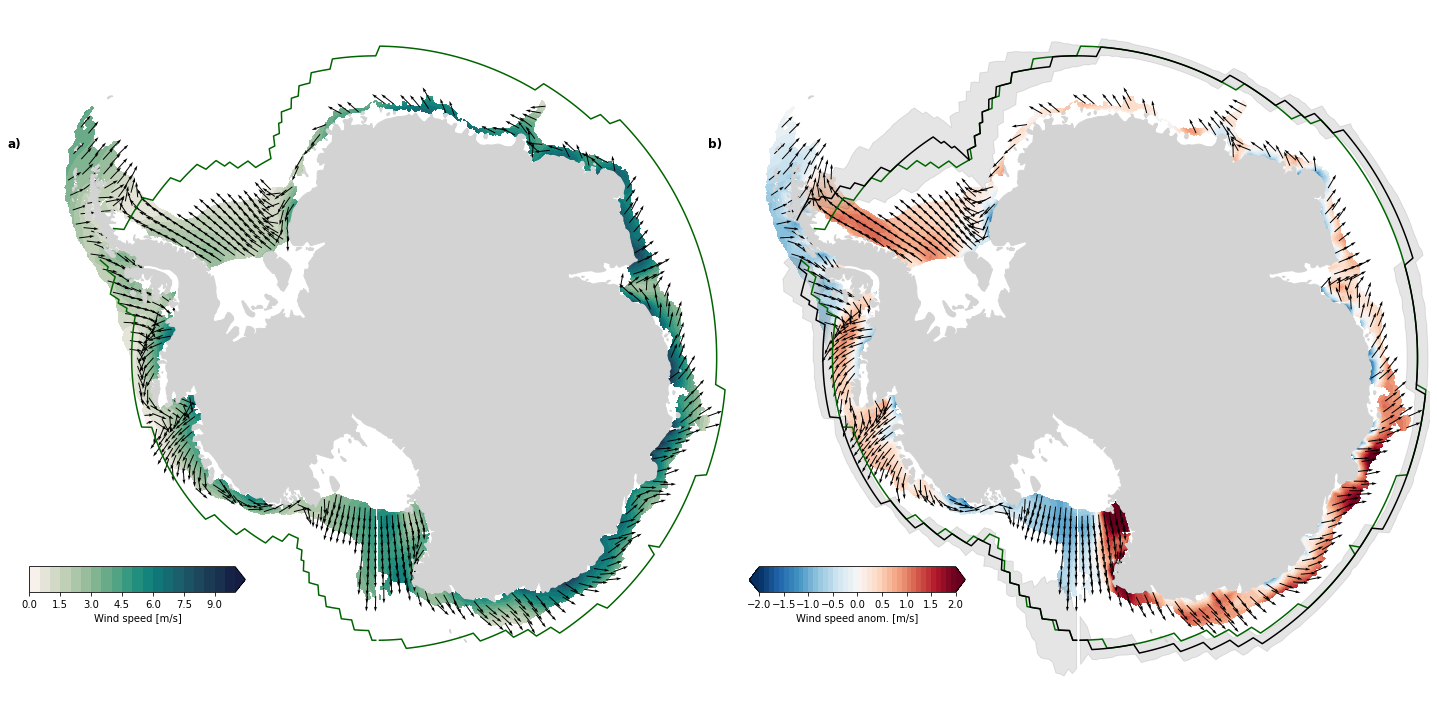

In [16]:
fig, axs = southern_ocean_plot_2()
# ERA Interim
c = axs[0].contourf(uas_finer['ERAI']['lon'], uas_finer['ERAI']['lat'], ws_finer['ERAI']*shelf_mask, 
                    levels = np.arange(0, 10.5, .5), extend = 'max', cmap = cmocean.cm.tempo, transform = ccrs.PlateCarree())
fig.colorbar(c, cax = fig.add_axes([0.02, 0.23, 0.15, 0.03]) , orientation = 'horizontal').set_label('Wind speed [m/s]')
axs[0].quiver(uas_finer['ERAI']['lon'].values[::20], uas_finer['ERAI']['lat'].values[::15], 
             (uas_finer['ERAI']*shelf_mask/ws_finer['ERAI']).values[::15,::20], (vas_finer['ERAI']*shelf_mask/ws_finer['ERAI']).values[::15,::20],
              scale = 45, width = 1.4e-3, transform = ccrs.PlateCarree())
axs[0].plot(zero_wind_lat['ERAI']['lon'], zero_wind_lat['ERAI'], color = 'darkgreen', transform = ccrs.PlateCarree())
# CMIP5 multimodel mean
c = axs[1].contourf(uas_finer['ERAI']['lon'], uas_finer['ERAI']['lat'], (ws_finer['CMIP6']-ws_finer['ERAI'])*shelf_mask, 
                    levels = np.arange(-2, 2.1, .1), extend = 'both', cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[1].quiver(uas_finer['ERAI']['lon'].values[::20], uas_finer['ERAI']['lat'].values[::15], 
             (uas_finer['CMIP6']*shelf_mask/ws_finer['CMIP6']).values[::15,::20], (vas_finer['CMIP6']*shelf_mask/ws_finer['CMIP6']).values[::15,::20],
              scale = 45, width = 1.4e-3, transform = ccrs.PlateCarree())
fig.colorbar(c, cax = fig.add_axes([0.52, 0.23, 0.15, 0.03]) , orientation = 'horizontal').set_label('Wind speed anom. [m/s]')
axs[1].plot(zero_wind_lat['ERAI']['lon'], zero_wind_lat['ERAI'], color = 'darkgreen', transform = ccrs.PlateCarree())
axs[1].plot(zero_wind_lat['CMIP6']['lon'], zero_wind_lat['CMIP6'], color = 'k', transform = ccrs.PlateCarree())
axs[1].fill_between(zero_wind_lat['CMIP6']['lon'], zero_wind_lat['CMIP6']-zero_wind_std, zero_wind_lat['CMIP6']+zero_wind_std, 
                    color = 'k', alpha = 0.1, transform = ccrs.PlateCarree())

plt.tight_layout()
plt.savefig('../results/fig1.png', facecolor = 'white', bbox_inches = 'tight')

# Trends of historical period
Calculated from annual composites (as Hazel)

In [16]:
uas_trends = {}
vas_trends = {}
for n in ['ERAI', 'CMIP6']:
    u = uas[n]['uas'].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends[n] = MK_class.compute()
    
    v = vas[n]['vas'].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends[n] = MK_class.compute()

In [17]:
uas_trends_finer = {}
vas_trends_finer = {}
for n in ['ERAI', 'CMIP6']:
    uas_trends[n] = uas_trends[n].rename({'x':'lon', 'y':'lat'})
    vas_trends[n] = vas_trends[n].rename({'x':'lon', 'y':'lat'})
    uas_trends_finer[n] = uas_trends[n].interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
    vas_trends_finer[n] = vas_trends[n].interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])

In [57]:
def southern_ocean_plot_4():
    fig = plt.figure(figsize = (20,19))
    gr = gs.GridSpec(2, 2, figure = fig, hspace = -0.2, wspace = -0.1); 
    axs = [fig.add_subplot(gr[0,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo())]
    for ax, lb in zip(axs, ['a)', 'b)', 'c)', 'd)']):
        ax.set_extent([-180, 180, -90, -63], ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'))
        ax.spines['geo'].set_edgecolor(None)
        ax.text(-0.03, .8, lb, transform=ax.transAxes, size = 12, weight='bold')
        ax.patch.set_alpha(0)
    return fig, axs

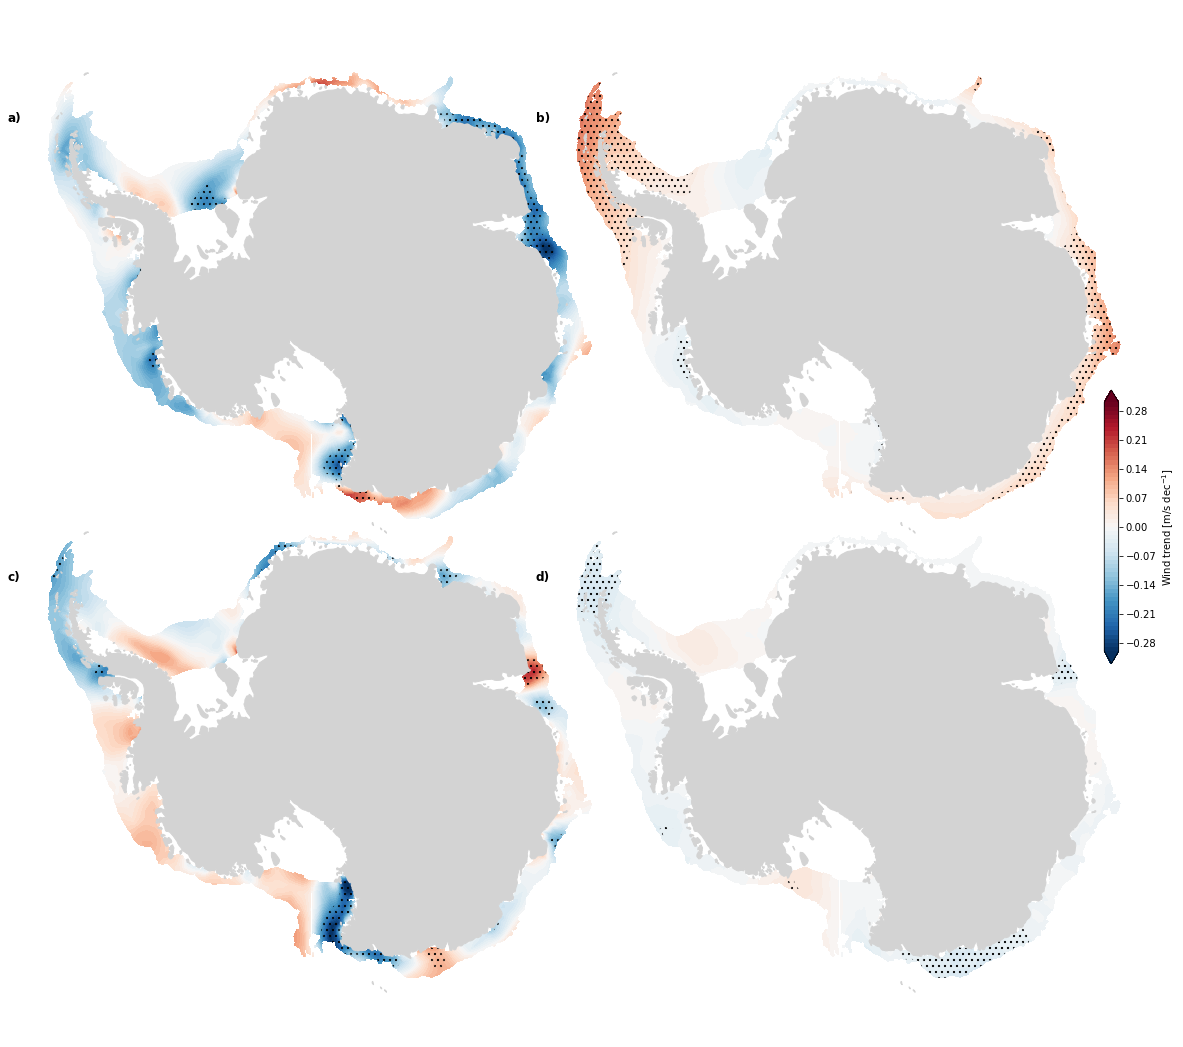

In [61]:
fig, axs = southern_ocean_plot_4()

cu = axs[0].contourf(uas_trends_finer['ERAI']['lon'], uas_trends_finer['ERAI']['lat'], 10*uas_trends_finer['ERAI']['trend']*shelf_mask, 
                     levels = np.arange(-.3, .31, .01), extend = 'both', cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[0].contourf(uas_trends_finer['ERAI']['lon'], uas_trends_finer['ERAI']['lat'], uas_trends_finer['ERAI']['p'].where(uas_trends_finer['ERAI']['p'] <= .05)*shelf_mask,
                colors = ['none'], hatches = ['..'], transform = ccrs.PlateCarree())
axs[2].contourf(vas_trends_finer['ERAI']['lon'], vas_trends_finer['ERAI']['lat'], 10*vas_trends_finer['ERAI']['trend']*shelf_mask, 
               levels = np.arange(-.3, .31, .01), extend = 'both', cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[2].contourf(vas_trends_finer['ERAI']['lon'], vas_trends_finer['ERAI']['lat'], vas_trends_finer['ERAI']['p'].where(vas_trends_finer['ERAI']['p'] <= .05)*shelf_mask,
                  colors = ['none'], hatches = ['..'], transform = ccrs.PlateCarree())

cv = axs[1].contourf(uas_trends_finer['CMIP6']['lon'], uas_trends_finer['CMIP6']['lat'], 10*uas_trends_finer['CMIP6']['trend']*shelf_mask, 
                     levels = np.arange(-.3, .31, .01), extend = 'both', cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[1].contourf(uas_trends_finer['CMIP6']['lon'], uas_trends_finer['CMIP6']['lat'], uas_trends_finer['CMIP6']['p'].where(uas_trends_finer['CMIP6']['p'] <= .05)*shelf_mask,
                colors = ['none'], hatches = ['..'], transform = ccrs.PlateCarree())
axs[3].contourf(vas_trends_finer['CMIP6']['lon'], vas_trends_finer['CMIP6']['lat'], 10*vas_trends_finer['CMIP6']['trend']*shelf_mask, 
               levels = np.arange(-.3, .31, .01), extend = 'both', cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[3].contourf(vas_trends_finer['CMIP6']['lon'], vas_trends_finer['CMIP6']['lat'], vas_trends_finer['CMIP6']['p'].where(vas_trends_finer['CMIP6']['p'] <= .05)*shelf_mask,
                  colors = ['none'], hatches = ['..'], transform = ccrs.PlateCarree())
fig.colorbar(cv, cax = fig.add_axes([0.88, 0.4, 0.01, 0.2]) , orientation = 'vertical').set_label('Wind trend [m/s dec$^{-1}$]')
plt.tight_layout()
plt.savefig('../results/fig2.png', facecolor = 'white', bbox_inches = 'tight')

# Climatology

In [62]:
uas_clim = {}
vas_clim = {}
ws_clim = {}
for n in ['ERAI', 'CMIP6']:
    uas_clim[n] = uas[n]['uas'].groupby('time.season').mean('time')
    vas_clim[n] = vas[n]['vas'].groupby('time.season').mean('time')
    ws_clim[n] = np.sqrt(uas_clim[n]**2+vas_clim[n]**2)

In [64]:
uas_clim_finer = {}
vas_clim_finer = {}
ws_clim_finer = {}
for n in ['ERAI', 'CMIP6']:
    uas_clim_finer[n] = uas_clim[n].interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
    vas_clim_finer[n] = vas_clim[n].interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
    ws_clim_finer[n] = ws_clim[n].interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])

In [77]:
def southern_ocean_plot_8():
    fig = plt.figure(figsize = (20, 10))
    gr = gs.GridSpec(2, 4, figure = fig, hspace = -0.2, wspace = 0); 
    axs = [fig.add_subplot(gr[0,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,1], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,2], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[0,3], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,0], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,1], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,2], projection = ccrs.SouthPolarStereo()),
           fig.add_subplot(gr[1,3], projection = ccrs.SouthPolarStereo())]
    for ax, lb in zip(axs, ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)']):
        ax.set_extent([-180, 180, -90, -63], ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'lightgrey', facecolor = 'lightgrey'))
        ax.spines['geo'].set_edgecolor(None)
        ax.text(-0.03, .8, lb, transform=ax.transAxes, size = 12, weight='bold')
        ax.patch.set_alpha(0)
    return fig, axs

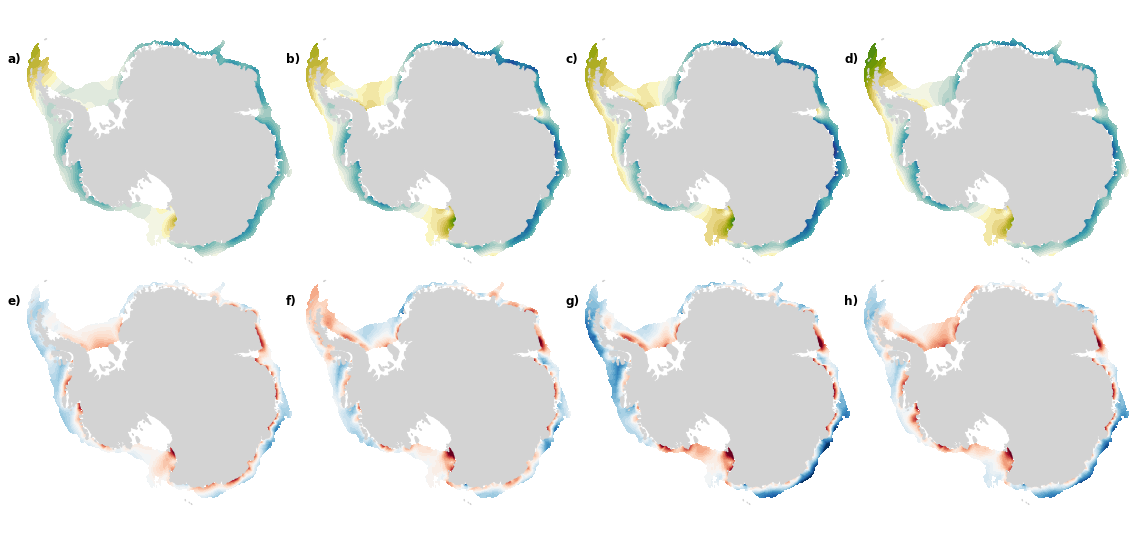

In [83]:
fig, axs = southern_ocean_plot_8()
for n, s in zip([0,1,2,3], ['DJF', 'MAM', 'JJA', 'SON']):
    axs[n].contourf(uas_clim_finer['ERAI']['lon'], uas_clim_finer['ERAI']['lat'], uas_clim_finer['ERAI'].sel(season = s)*shelf_mask, 
                    levels = np.arange(-10, 10.5, .5), cmap = cmocean.cm.delta, extend = 'both', transform = ccrs.PlateCarree())
    axs[n+4].contourf(uas_clim_finer['CMIP6']['lon'], uas_clim_finer['CMIP6']['lat'], (uas_clim_finer['CMIP6'].sel(season = s)-uas_clim_finer['ERAI'].sel(season = s))*shelf_mask, 
                      levels = np.arange(-2, 2.1, .1), cmap = 'RdBu_r', extend = 'both', transform = ccrs.PlateCarree())

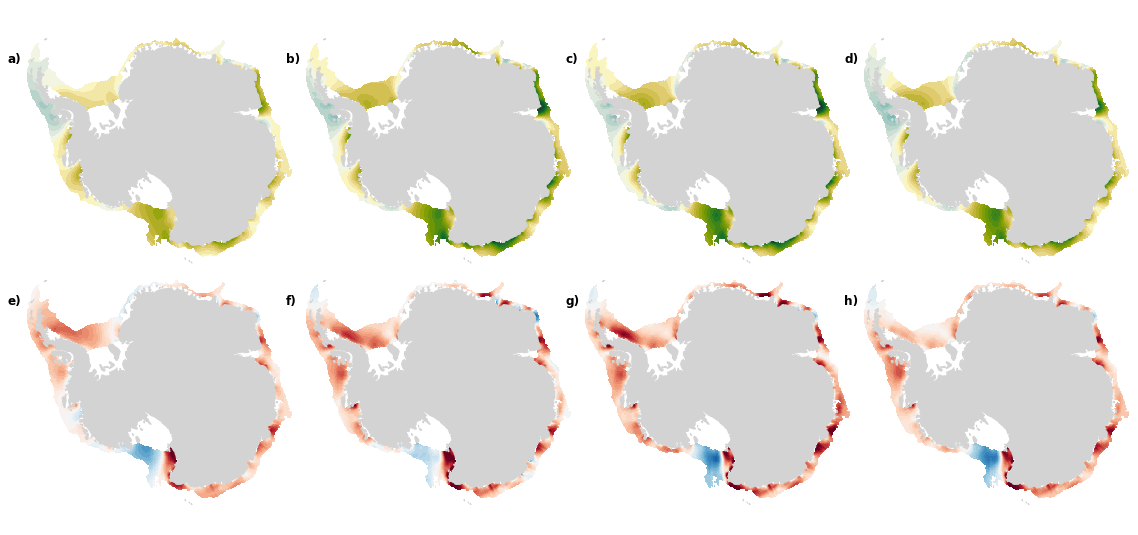

In [84]:
fig, axs = southern_ocean_plot_8()
for n, s in zip([0,1,2,3], ['DJF', 'MAM', 'JJA', 'SON']):
    axs[n].contourf(vas_clim_finer['ERAI']['lon'], vas_clim_finer['ERAI']['lat'], vas_clim_finer['ERAI'].sel(season = s)*shelf_mask, 
                    levels = np.arange(-10, 10.5, .5), cmap = cmocean.cm.delta, extend = 'both', transform = ccrs.PlateCarree())
    axs[n+4].contourf(vas_clim_finer['CMIP6']['lon'], vas_clim_finer['CMIP6']['lat'], (vas_clim_finer['CMIP6'].sel(season = s)-vas_clim_finer['ERAI'].sel(season = s))*shelf_mask, 
                      levels = np.arange(-2, 2.1, .1), cmap = 'RdBu_r', extend = 'both', transform = ccrs.PlateCarree())